<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Simple_Bayesian_Change_Point_Detection_with_Pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Change-Point Detection in Pymc3

### Import Packages

In [1]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Styling
%matplotlib inline
plt.style.use('fivethirtyeight')

### Generate Data

The code below generates a Gaussian timeseries with 20 observations and a shift in mean from 0 to 5 at the 10th timestep.  Additionally, it has standard deviation 2, making it fairly challenging for a changepoint detection system.

In [142]:
y1 = np.random.normal(0,2,10)
y2 = np.random.normal(5,2,10)
y = np.append(y1,y2)

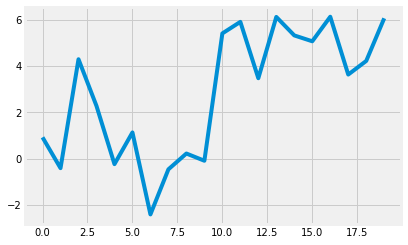

In [144]:
plt.plot(y)

## Build Model

Below, a model object is constructed and used under the alias "model".  First, the prior distributions are defined.  "Beta" is a random Normal variable that will be estimated as the mean.  Since this is a changepoint system, it is specified twice (one for each side of the changepoint if there is one).  Next, sigma is defined as a HalfNormal random variable as it must be positive.  Worth noting, it is defined for the entire model, whether before or after a changepoint and assumes stable variance through the changes.  Finally, changepoint is defined as a DiscreteUniform random variable as the timesteps it will be wieghting/de-wieghting are discrete.  

After, the switch function is initialized as Deterministic since it only contains inherited uncertainty, but is nothing more than a function making both betas available to the changepoint parameter.  

Next, the final model is established as a random Normal variable with mean and standard deviation being set by the priors and/or thier optimized posteriors.  It is bound to the observed data (y).
Finally, trace samples from the model to optimize its parameters, and then provides a set of sampled data as a posterior distribution for further use.

In [146]:
ts_length = 20

with pm.Model() as model:
    # Priors
    beta = pm.Normal("beta", mu=0, sigma=5, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    changepoint = pm.DiscreteUniform("changepoint", lower=0, upper=ts_length)

    # Switch Function
    mu = pm.Deterministic('mu', pm.math.switch(changepoint > np.arange(ts_length), beta[0], beta[1]))

    # Model
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

    # Sample Posterior Distribution
    trace = pm.sample(3000, chains=2, return_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigma, beta]
>Metropolis: [changepoint]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


## Evaluate Model and Analyze Performance

### View Model as Bayesian Graphical Model

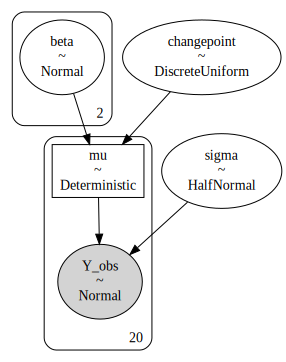

In [147]:
pm.model_to_graphviz(model)

### Summary Statistics for Model Parameters

The summary show that beta[0] and beta[1] were very close to the actual pre- and post-change means of 0 and 5, respectively.  Additionally, the changepoint was picked up with incredible accuracy, as the pmf's mean was only 0.010 off the correct point of 10.

In [148]:
az.summary(trace, kind='stats', var_names=['beta','sigma','changepoint'])

,mean,sd,hdi_3%,hdi_97%
beta[0],0.544,0.488,-0.322,1.491
beta[1],5.090,0.485,4.206,6.001
sigma,1.475,0.240,1.065,1.929
changepoint,10.010,0.132,10.000,10.000


### Plot Posterior Distributions

The posteriors look good and reinforce the numerical results.  Additionally, they show that both betas are roughly normally distributed, that sigma is close to normal except for its long tail, and that changepoint is parked at ten.

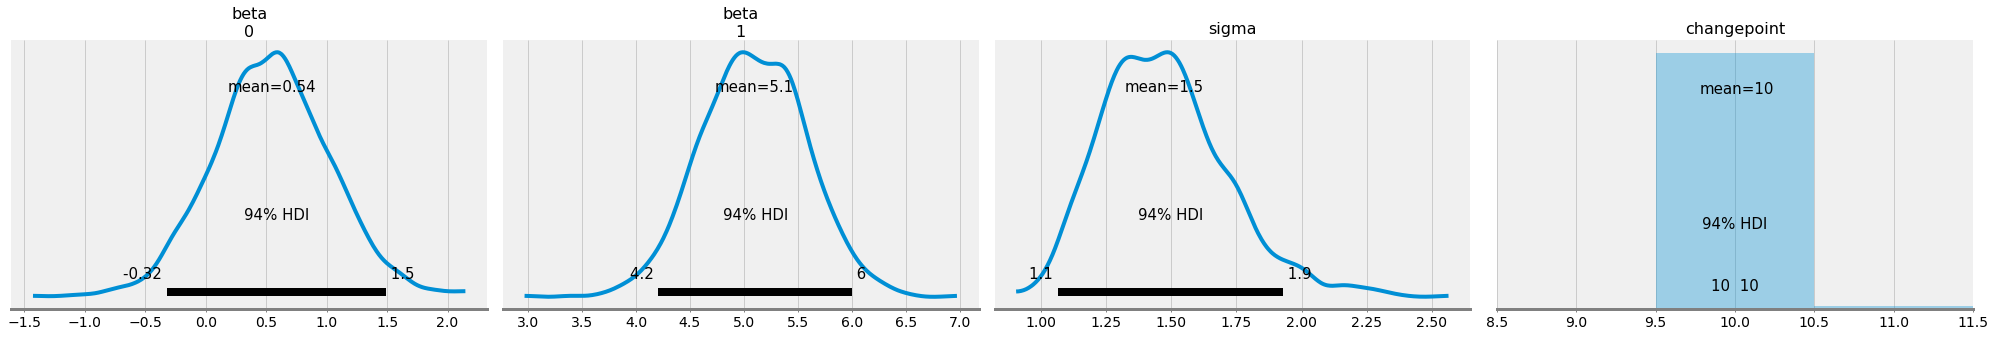

In [150]:
az.plot_posterior(trace, var_names=['beta','sigma','changepoint'])
plt.show()

## Conclusion

The model performed well.  It was able to detect the changepoint with incredible accuracy amidst a substantial amount of noise.

In future versions, sigma could be duplicated to cover situations where it shifts with beta.  Additionally, a user parameter allowing for more betas (i.e. more changepoints) would also be useful, since so many timeseries have multiple interventions/changes influencing them simultaneously.